<div align="center">

# **CS-E4650 Methods of Data Mining**

# **Exercise 2.4 Homework: Balls and spirals**

</div>

:<div align="center">
    
# **Group members**

# **Nguyen Xuan Binh (887799)**

# **Erald Shahinas (906845)**

# **Alexander Pavlyuk (906829)**

</div>

</br>
</br>
</br>

# **Table of Contents**

### 1. [Methods](#1)
### 2. [Clustering of the balls data](#2)
### 3. [Clustering of the spirals data](#3)
### 4. [Analysis of results](#4)
### 5. [2-D spectral embedding of the sprirals data](#5)
### 6. [Appendix](#6)

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

## **1. Methods**

All the calculations have been perfomed on JypyterHub (https://jupyter.cs.aalto.fi) in the Python notebook. Additionally, numpy (https://numpy.org/), matplotlib (https://matplotlib.org/), pandas (https://pandas.pydata.org/), and scikit-learn (https://scikit-learn.org/stable/index.html) libraries have been imported to handle specific functions.


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
# Create a balls dataframe
balls_df = pd.read_csv('balls.txt', header = 0)
print("Balls data text")
print(balls_df.head())

# Create a spirals dataframe
spirals_df = pd.read_csv('spirals.txt', header = 0)
print("\nSpirals data text")
print(spirals_df.head())

Balls data text
       X       Y  class
0 -6.244  6.6637      0
1 -8.194  7.5372      0
2  1.732 -0.6362      2
3 -6.137 -5.1643      1
4 -7.424  6.4897      0

Spirals data text
       X     Y  class
0  31.95  7.95      3
1  31.15  7.30      3
2  30.45  6.65      3
3  29.70  6.00      3
4  28.90  5.55      3


We will use the first two columns as features and the last as the label.

In [ ]:
# features
balls = balls_df.iloc[:,0:2].to_numpy()
spirals = spirals_df.iloc[:, 0:2].to_numpy()

# labels
balls_true_labels = balls_df.iloc[:,2].to_numpy()
spirals_true_labels = spirals_df.iloc[:, 2].to_numpy()

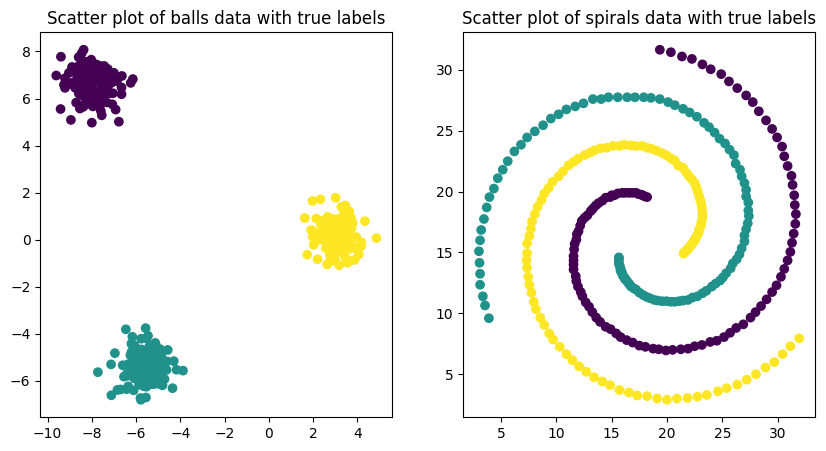

In [ ]:
# Plot the data sets

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(balls[:,0], balls[:,1], c=balls_true_labels)
ax[0].set_title("Scatter plot of balls data with true labels")

ax[1].scatter(spirals[:,0], spirals[:,1], c=spirals_true_labels)
ax[1].set_title("Scatter plot of spirals data with true labels")

plt.show()

## **2. Clustering of the balls data**

(Warm-up) Cluster “balls.txt” with

__i) K-means__

__ii) spectral clustering__ using a Gaussian kernel and a Laplacian matrix of your choice.

You can try different values of the kernel parameter, to see if it has any effect. Note: if you are using a software package, try to figure out
which Laplacian matrix it uses. The distance measure is Euclidean.

Test values $K = 2,...,5$ and determine the optimal number of clusters for both methods using all three indices (SI, CH, NMI). Report the results as a table. Which method and K are best for the data?

#### __i) Clustering Balls with K-means__

#### K-means algorithm

In [ ]:
def euclidean2D(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))


def kmeans(X_train, n_clusters, max_iter=100, etol=1e-50):
    # Randomly select centroid start points, uniformly distributed across the domain of the dataset
    # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
    # centroids = np.array([np.array(uniform(min_, max_)) for _ in range(n_clusters)])
    # Chose random datapoints as centroids
    centroids = X_train[np.random.choice(X_train.shape[0], n_clusters, replace=False), :]
    # Iterate, adjusting centroids until converged or until passed max_iter
    iteration = 0
    prev_centroids = np.inf * np.ones(centroids.shape)
    while np.any(np.array([euclidean_distance(centroids[i], prev_centroids[i]) for i in range(n_clusters)])
                 > etol) and iteration < max_iter:
        # Sort each datapoint, assigning to nearest centroid
        sorted_points = [[] for _ in range(n_clusters)]
        for x in X_train:
            dists = euclidean2D(x, centroids)
            centroid_idx = np.argmin(dists)
            sorted_points[centroid_idx].append(x)
        # Push current centroids to previous, reassign centroids as mean of the points belonging to them
        prev_centroids = centroids
        centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
        for i, centroid in enumerate(centroids):
            if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                centroids[i] = prev_centroids[i]
        iteration += 1

    labels = []

    for x in X_train:
        dists = euclidean2D(x, centroids)
        centroid_idx = np.argmin(dists)
        labels.append(centroid_idx)

    return np.array(labels), np.array(centroids)

#### Clustering indices

#### **Silhouette Index**

$$S(x) = \begin{cases} 0 & \text{if } x \text{ a cluster of its own} \\ \frac{b-a}{\max\{a,b\}} & \text{otherwise} \end{cases}$$

$a = avg\{d(x, y) | x ∈ C, y ∈ C\}$

a is the average distance between point i and the other points in the same cluster C.

$b = min_q avg\{d(x, y) | x ∈ C, y ∈ C_q,C , C_q\}$

b is the average distance between point i and the other points from every cluster except the cluster b is part of.

$AverageSI = \frac{1}{N} \sum_{i=1}^{N} S(i) $

The Silhouette Index takes values from the interval [-1,1]. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The average Silhouette Index is the average for all points.

#### **Calinski Harabasz Index**

\begin{gather*}
CH = \frac{\sum_{j=1}^{K}{n_k||c_k-c||^2}}{\sum_{k=1}^{K}{\sum_{i=1}^{n_k}{||d_i-c_k||^2}}}\times\frac{N-K}{K-1}
\text{, where}\\\\
\text{K - the number of clusters,}\\
n_k\text{ and }c_k\text{ - the number of points and centroid of the }k^{th}\text{ cluster respectively,}\\
c\text{ - the global centroid,}\\
N\text{ - the total number of data points.}
\end{gather*}

The range of the Calinski Harabasz index is $[0,~\inf[$. Higher values are better and indicate dense, well-separated clusters.


#### **Normalized Mutual Information**

\begin{gather*}
H(U)=-\sum_{i=1}^{|U|}{\frac{|U_i|}{N}\log\left(\frac{|U_i|}{N}\right)}\text{, similarly for H(V)}\\
MI(U,V)=\sum_{i=1}^{|U|}\sum_{j=1}^{|V|}{\frac{|U_i\cap V_j|}{N}\log\left(\frac{N|U_i\cap V_j|}{|U_i||V_j|}\right)}\\
NMI(U, V)=\frac{MI(U, V)}{mean(H(U),H(V))}
\end{gather*}


The range of the Normalized Mutual Information is [0,1] with 1 indicating perfect clustering and a score of 0 indicating completely independent clusterings.




In [ ]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def silhouette_index(X, labels):
    # Calculate pairwise distances
    n_samples = X.shape[0]
    pairwise_distances = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            pairwise_distances[i, j] = euclidean_distance(X[i], X[j])

    silhouette_scores = []

    for i in range(X.shape[0]):
        # Average distance to points in the same cluster
        same_cluster = labels == labels[i]
        a_i = np.mean(pairwise_distances[i, same_cluster])

        # Average distance to points in the next nearest cluster
        other_clusters = np.unique(labels[labels != labels[i]])
        b_i_values = [np.mean(pairwise_distances[i, labels == cluster]) for cluster in other_clusters]
        b_i = min(b_i_values)

        silhouette_scores.append((b_i - a_i) / max(a_i, b_i))

    return np.mean(silhouette_scores)

def calinski_harabasz_index(X, labels):
    n_samples = X.shape[0]
    n_clusters = len(np.unique(labels))

    overall_mean = np.mean(X, axis=0)
    cluster_means = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Between-cluster dispersion
    B = sum([len(X[labels == i]) * euclidean_distance(cluster_means[i], overall_mean)**2 for i in range(n_clusters)])
    # Within-cluster dispersion
    W = sum([sum([euclidean_distance(X[j], cluster_means[labels[j]])**2 for j in range(n_samples) if labels[j] == i]) for i in range(n_clusters)])
    # The CH Index
    CH = (B * (n_samples - n_clusters)) / (W * (n_clusters - 1))

    return CH

def normalized_mutual_info_index(true_labels, pred_labels):

    contingency_matrix = np.histogram2d(true_labels, pred_labels)[0]
    contingency_matrix /= contingency_matrix.sum()
    prob_true = np.sum(contingency_matrix, axis=1)
    prob_cluster = np.sum(contingency_matrix, axis=0)

    # Mutual information
    I = 0.0
    for i in range(contingency_matrix.shape[0]):
        for j in range(contingency_matrix.shape[1]):
            if contingency_matrix[i][j] > 0:
                I += contingency_matrix[i][j] * np.log(contingency_matrix[i][j] / (prob_true[i] * prob_cluster[j]))

    # The entropy of the true labels
    prob_true = np.bincount(true_labels) / len(true_labels)
    H_U = -np.sum(prob_true * np.log(prob_true + np.finfo(float).eps))

    # The entropy of the cluster labels
    prob_cluster = np.bincount(pred_labels) / len(pred_labels)
    H_V = -np.sum(prob_cluster * np.log(prob_cluster + np.finfo(float).eps))

    NMI = 2 * I / (H_U + H_V)
    return NMI

#### Clustering Balls with different K values

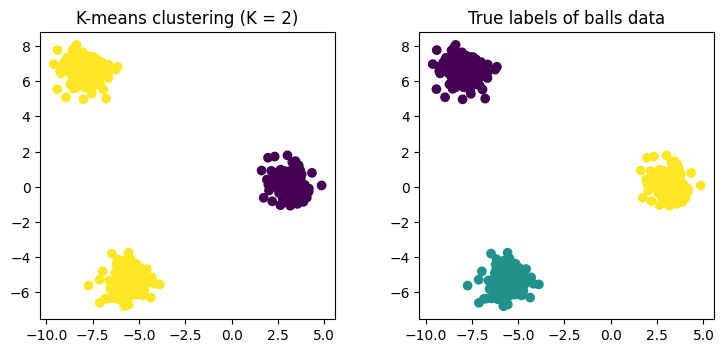

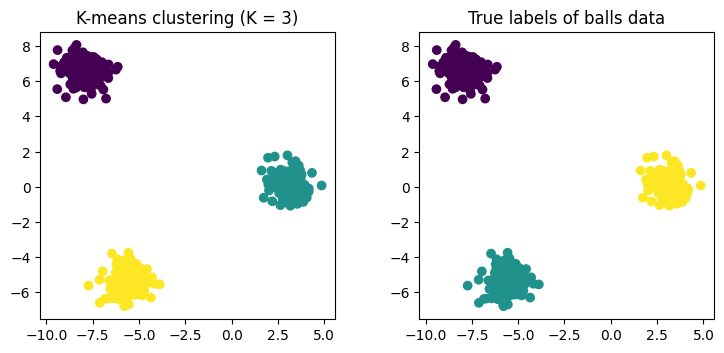

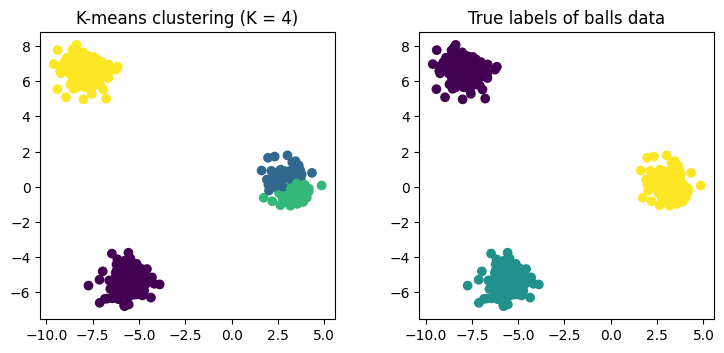

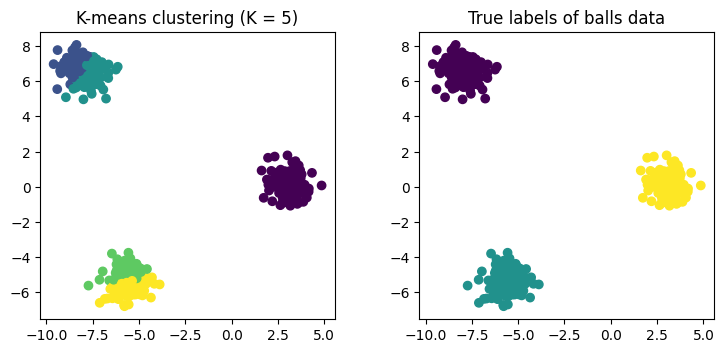

In [ ]:
# Define the number of clusters
K = [2,3,4,5]

# Construct a table to store the results
df_results = pd.DataFrame(columns=["K", "Silhouette", "Calinski-Harabasz", "NMI"])

for i, k in enumerate(K):
    pred_labels, centroids = kmeans(X_train=balls, n_clusters=k)

    # Model Sklearn
    #result = KMeans(n_clusters = k, n_init="auto").fit(balls)
    #pred_labels, centroids = result.labels_, result.cluster_centers_

    fig, ax = plt.subplots(1,2, figsize=(8,4))
    fig.tight_layout(pad=3.0)
    ax[0].scatter(balls[:,0], balls[:,1], c=pred_labels)
    ax[0].set_title(f"K-means clustering (K = {k})")
    ax[1].scatter(balls[:,0], balls[:,1], c=balls_true_labels)
    ax[1].set_title("True labels of balls data")
    plt.show()

    # Model Sklearn
    print("=" * 60)
    # print(f"Indices of K = {k}")
    #print("Silhouette score: ", round(silhouette_score(balls, pred_labels), 4))
    #print("Calinski-Harabasz score: ", round(calinski_harabasz_score(balls, pred_labels), 4))
    #print("Normalized mutual information score: ", round(normalized_mutual_info_score(balls_true_labels, pred_labels), 4))

    silhouette_clustering_score = round(silhouette_index(balls, pred_labels), 4)
    calinski_harabasz_clustering_score = round(calinski_harabasz_index(balls, pred_labels), 4)
    normalized_mutual_info_clustering_score = round(normalized_mutual_info_index(balls_true_labels, pred_labels), 4)

    df_results.loc[i] = [k, silhouette_clustering_score, calinski_harabasz_clustering_score, normalized_mutual_info_clustering_score]

In [ ]:
print("Score indices of K-means clustering\n")
print(df_results)

Score indices of K-means clustering

     K  Silhouette  Calinski-Harabasz     NMI
0  2.0      0.5787           329.7146  0.7337
1  3.0      0.9023         12594.7828  1.0000
2  4.0      0.7112          9376.7765  0.9061
3  5.0      0.5125          8211.6358  0.8278


We can observe that the best number of clusters for the Balls dataset is K=3 according to all three scores based on K-means clustering. This is confirmed since NMI score of $K = 3$ is equal to 1.0, indicating that the clustering matches the true labels

#### __ii) Clustering Balls with Spectral clustering__

This time we use the Sklearn library for Spectral Clustering instead of implementing from scratch like K-means method previously. Since we are using a software package, the Laplacian matrix of Sklearn SpectralCLustering uses is defined as the normalized Laplacian matrix. The kernel that we choose is the RBF kernel, whose formula is:


$K(x,y) = exp\left(-\dfrac{||x-y||^2}{2\sigma^2} \right) = exp\left(- \gamma ||x-y||^2 \right) $

Therefore, we would test SpectralClustering with two $\gamma$ values for the RBF kernel:
1. $\gamma = $ 1/(n_features) (Sklearn default option)
2. $\gamma = \dfrac{1}{2\sigma^2}$  

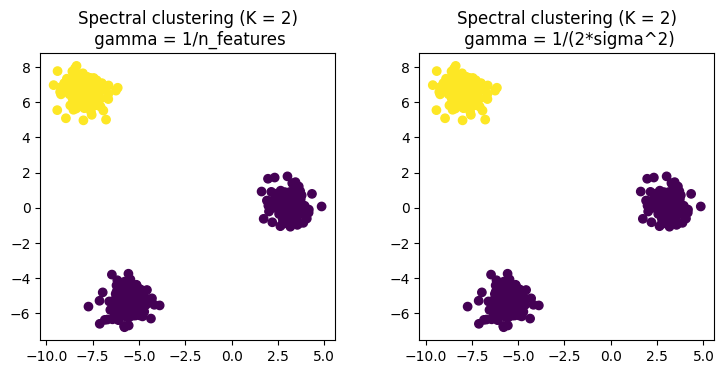

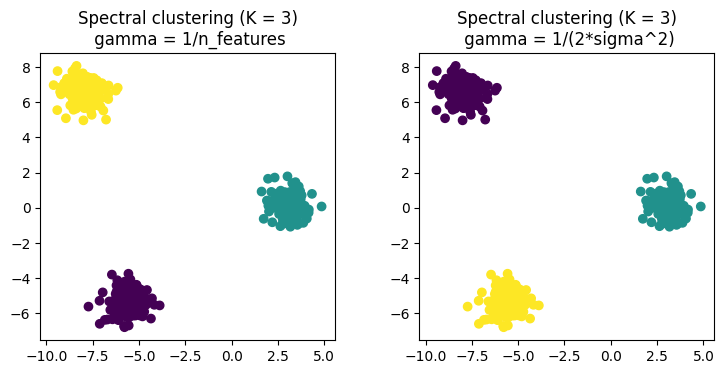

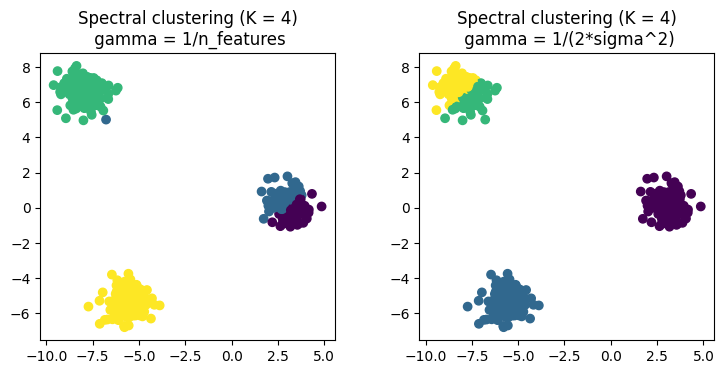

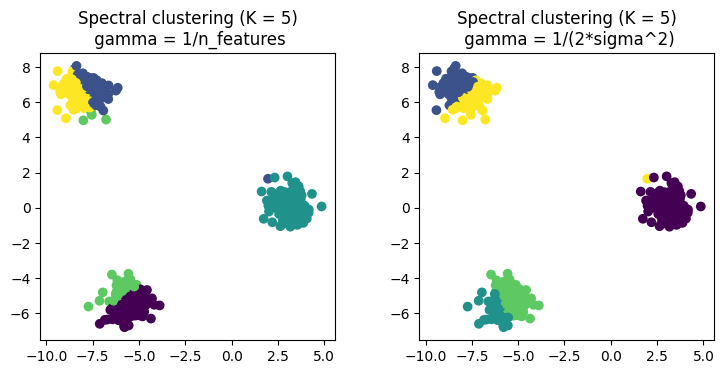

In [ ]:
# Define the number of clusters
K = [2,3,4,5]

# Construct a table to store the results
df_results1 = pd.DataFrame(columns=["K", "Silhouette", "Calinski-Harabasz", "NMI"])
df_results2 = pd.DataFrame(columns=["K", "Silhouette", "Calinski-Harabasz", "NMI"])

for i, k in enumerate(K):

    # Affinity matrix defined by the RBF kernel

    # gamma = 1/n_features
    n_features = balls.shape[0]
    balls_affinity = rbf_kernel(balls, gamma = 1.0 / n_features)
    result = SpectralClustering(n_clusters=k, affinity='precomputed').fit(balls_affinity)
    pred_labels1 = result.labels_

    # gamma = 1/(2*sigma^2)
    sigma = balls.std()
    balls_affinity = rbf_kernel(balls, gamma = 1.0 / (2 * sigma ** 2))
    result = SpectralClustering(n_clusters=k, affinity='precomputed').fit(balls_affinity)
    pred_labels2 = result.labels_

    fig, ax = plt.subplots(1,2, figsize=(8,4))
    fig.tight_layout(pad=3.0)
    ax[0].scatter(balls[:,0], balls[:,1], c=pred_labels1)
    ax[0].set_title(f"Spectral clustering (K = {k})\n gamma = 1/n_features")
    ax[1].scatter(balls[:,0], balls[:,1], c=pred_labels2)
    ax[1].set_title(f"Spectral clustering (K = {k})\n gamma = 1/(2*sigma^2)")
    plt.show()

    # Model Sklearn
    print("=" * 60)
    #print(f"Indices of K = {k}")

    silhouette_clustering_score1 = round(silhouette_index(balls, pred_labels1), 4)
    calinski_harabasz_clustering_score1 = round(calinski_harabasz_index(balls, pred_labels1), 4)
    normalized_mutual_info_clustering_score1 = round(normalized_mutual_info_index(balls_true_labels, pred_labels1), 4)

    silhouette_clustering_score2 = round(silhouette_index(balls, pred_labels2), 4)
    calinski_harabasz_clustering_score2 = round(calinski_harabasz_index(balls, pred_labels2), 4)
    normalized_mutual_info_clustering_score2 = round(normalized_mutual_info_index(balls_true_labels, pred_labels2), 4)

    df_results1.loc[i] = [k, silhouette_clustering_score1, calinski_harabasz_clustering_score1, normalized_mutual_info_clustering_score1]
    df_results2.loc[i] = [k, silhouette_clustering_score2, calinski_harabasz_clustering_score2, normalized_mutual_info_clustering_score2]

In [ ]:
print("Score indices of Spectral Clustering, gamma=1/n_features\n")
print(df_results1)

Score indices of Spectral Clustering, gamma=1/n_features

     K  Silhouette  Calinski-Harabasz     NMI
0  2.0      0.6694           634.1430  0.7349
1  3.0      0.9023         12594.7828  1.0000
2  4.0      0.6985          6625.1939  0.8958
3  5.0      0.5101          2553.4747  0.8015


In [ ]:
print("Score indices of Spectral Clustering, gamma=1/(2*sigma^2)\n")
print(df_results2)

Score indices of Spectral Clustering, gamma=1/(2*sigma^2)

     K  Silhouette  Calinski-Harabasz     NMI
0  2.0      0.6694           634.1430  0.7349
1  3.0      0.9023         12594.7828  1.0000
2  4.0      0.7143          9710.0721  0.9062
3  5.0      0.5262          5620.9605  0.8264


We can observe that when $\gamma = \dfrac{1}{2\sigma^2}$, the Spectral Clustering performs slightly better. Again, like K-means, Spectral Clustering also shows that the number of optimal clusters is $K = 3$

#### __Conclusions__

Both K-means and Spectral Clustering performs equally well on the Balls dataset and the optimal number of clusters is $K = 3$

## **3. Clustering of the spirals data**

First, we will cluster the spirals with K-means

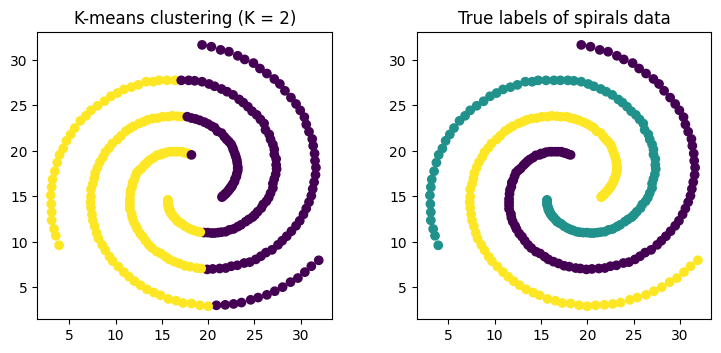

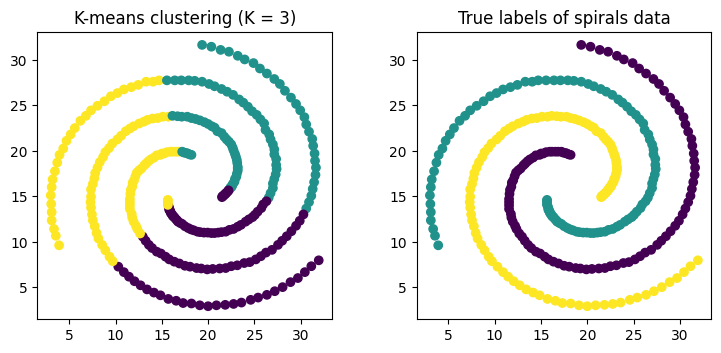

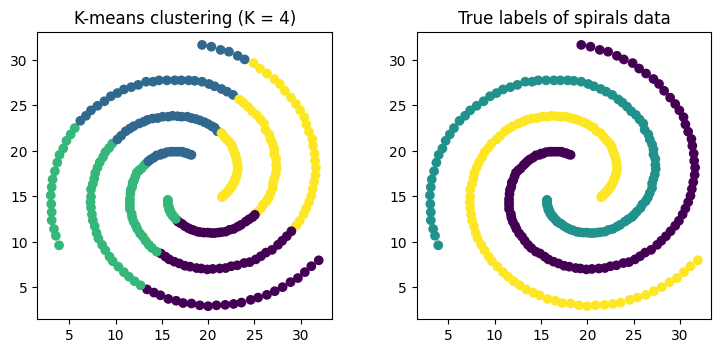

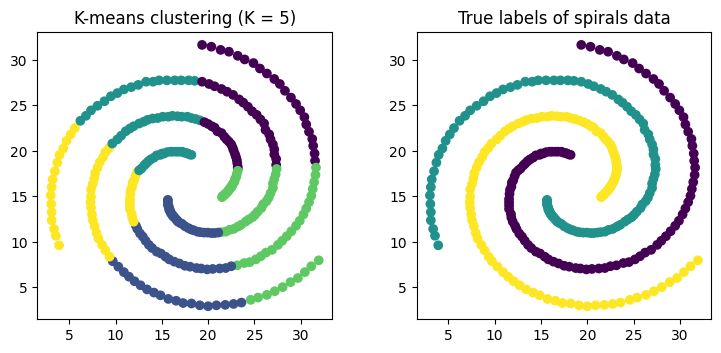

In [ ]:
# Define the number of clusters
K = [2,3,4,5]

# Construct a table to store the results
df_results = pd.DataFrame(columns=["K", "Silhouette", "Calinski-Harabasz", "NMI"])

for i, k in enumerate(K):
    pred_labels, centroids = kmeans(X_train=spirals, n_clusters=k)

    fig, ax = plt.subplots(1,2, figsize=(8,4))
    fig.tight_layout(pad=3.0)
    ax[0].scatter(spirals[:,0], spirals[:,1], c=pred_labels)
    ax[0].set_title(f"K-means clustering (K = {k})")
    ax[1].scatter(spirals[:,0], spirals[:,1], c=spirals_true_labels)
    ax[1].set_title("True labels of spirals data")
    plt.show()

    print("=" * 60)

    silhouette_clustering_score = round(silhouette_index(spirals, pred_labels), 4)
    calinski_harabasz_clustering_score = round(calinski_harabasz_index(spirals, pred_labels), 4)
    normalized_mutual_info_clustering_score = round(normalized_mutual_info_index(spirals_true_labels, pred_labels), 4)

    df_results.loc[i] = [k, silhouette_clustering_score, calinski_harabasz_clustering_score, normalized_mutual_info_clustering_score]

In [ ]:
print("Score indices of K-means clustering\n")
print(df_results)

Score indices of K-means clustering

     K  Silhouette  Calinski-Harabasz     NMI
0  2.0      0.3517           184.5817  0.0008
1  3.0      0.3676           237.4724  0.0007
2  4.0      0.3541           239.4348  0.0015
3  5.0      0.3560           249.2157  0.0068


We can see that NMI score of K-means is extremely low, which suggests that K-means perform very bad on the spirals dataset. Other scores of K-means are also very low on any number of clusters. Additionally, no number of clusters is noticeably better than the rest, so we cannot conclude the optimal number of clusters for the spirals based on K-means method

Secondly, we will cluster the spirals based on Spectral Clustering. The same settings are used like previously with the balls data. However, this time we use $\gamma=0.1$ to make the kernel decay much more quickly. That is, further Euclidean distances will be more heavily penalized. Conversely, we use $\gamma=0.001$ to make the kernel decay more slowly.

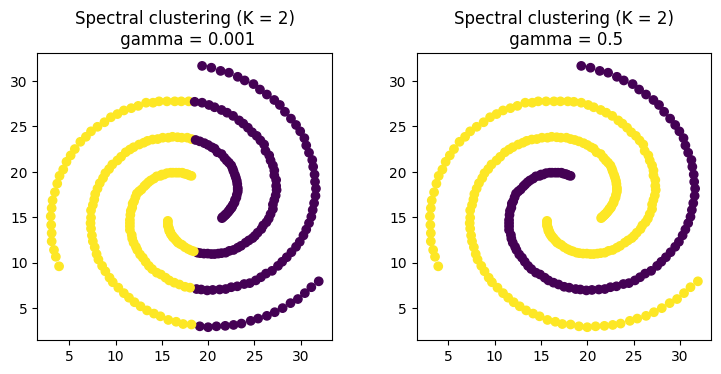

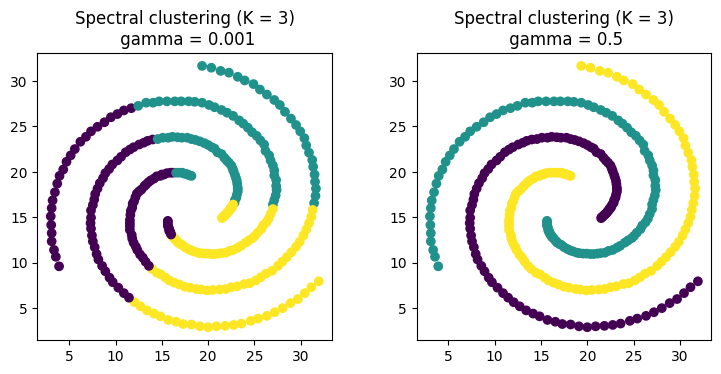

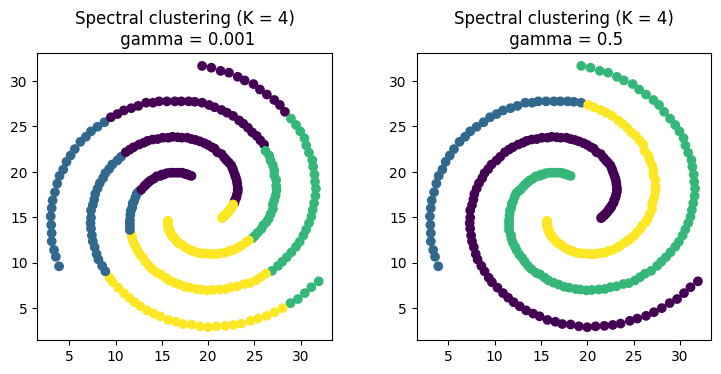

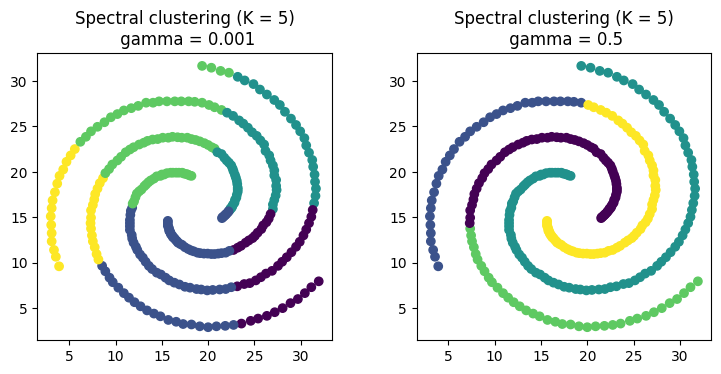

In [ ]:
# Define the number of clusters
K = [2,3,4,5]

# Construct a table to store the results
df_results1 = pd.DataFrame(columns=["K", "Silhouette", "Calinski-Harabasz", "NMI"])
df_results2 = pd.DataFrame(columns=["K", "Silhouette", "Calinski-Harabasz", "NMI"])

for i, k in enumerate(K):

    # Affinity matrix defined by the RBF kernel

    # gamma = 0.001
    n_features = spirals.shape[0]
    spirals_affinity = rbf_kernel(spirals, gamma = 0.001)
    result = SpectralClustering(n_clusters=k, affinity='precomputed').fit(spirals_affinity)
    #result = SpectralClustering(n_clusters=k).fit(spirals)
    pred_labels1 = result.labels_

    # gamma = 0.5
    sigma = spirals.std()
    spirals_affinity = rbf_kernel(spirals, gamma = 0.5)
    result = SpectralClustering(n_clusters=k, affinity='precomputed').fit(spirals_affinity)
    pred_labels2 = result.labels_

    fig, ax = plt.subplots(1,2, figsize=(8,4))
    fig.tight_layout(pad=3.0)
    ax[0].scatter(spirals[:,0], spirals[:,1], c=pred_labels1)
    ax[0].set_title(f"Spectral clustering (K = {k})\n gamma = 0.001")
    ax[1].scatter(spirals[:,0], spirals[:,1], c=pred_labels2)
    ax[1].set_title(f"Spectral clustering (K = {k})\n gamma = 0.5")
    plt.show()

    print("=" * 60)

    silhouette_clustering_score1 = round(silhouette_index(spirals, pred_labels1), 4)
    calinski_harabasz_clustering_score1 = round(calinski_harabasz_index(spirals, pred_labels1), 4)
    normalized_mutual_info_clustering_score1 = round(normalized_mutual_info_index(spirals_true_labels, pred_labels1), 4)

    silhouette_clustering_score2 = round(silhouette_index(spirals, pred_labels2), 4)
    calinski_harabasz_clustering_score2 = round(calinski_harabasz_index(spirals, pred_labels2), 4)
    normalized_mutual_info_clustering_score2 = round(normalized_mutual_info_index(spirals_true_labels, pred_labels2), 4)

    df_results1.loc[i] = [k, silhouette_clustering_score1, calinski_harabasz_clustering_score1, normalized_mutual_info_clustering_score1]
    df_results2.loc[i] = [k, silhouette_clustering_score2, calinski_harabasz_clustering_score2, normalized_mutual_info_clustering_score2]

In [ ]:
print("Score indices of Spectral Clustering, gamma=0.001\n")
print(df_results1)

Score indices of Spectral Clustering, gamma=0.001

     K  Silhouette  Calinski-Harabasz     NMI
0  2.0      0.3519           184.4237  0.0007
1  3.0      0.3657           237.6697  0.0004
2  4.0      0.3332           211.8419  0.0307
3  5.0      0.3370           221.2526  0.0345


In [ ]:
print("Score indices of Spectral Clustering, gamma=0.5\n")
print(df_results2)

Score indices of Spectral Clustering, gamma=0.5

     K  Silhouette  Calinski-Harabasz     NMI
0  2.0      0.0314             6.1499  0.7287
1  3.0      0.0105             5.7979  1.0000
2  4.0     -0.0010            24.5365  0.9112
3  5.0      0.0283            37.9647  0.8344


We can see that for $\gamma = 0.001$, the clustered result of Spectral method is the same as K-means. However, things get interesting when $\gamma$ is much larger (0.1). This time, the affinity of two points will be much larger if they are close neighbors, allowing the Spectral Clustering to separate the spirals like the true labels. The best number of clusters is $K = 3$ based on NMI score index of 1.0 when $\gamma = 0.5$   

__Conclusions__

Spectral Clustering performs better than the K-means on the Spirals dataset and the optimal number of clusters is $K = 3$ with the RBF kernel parameter $\gamma = 0.5$

## **4. Analysis of results**

Explain and analyze your observations. It is recommended to look at the definitions of indices to better understand their objectives. Plotting the best clusterings can also help in the interpretation.

### __Which index captured the performance of the algorithm most accurately?__

Naturally, the NMI index captured the performance of both algorithms more accurately. This is because NMI has a reference (true labels) to judge how good the clustering label assignment is. Additionally, NMI is normalized, so clusters of vastly different sizes will still not make NMI biased

### __Why some indices failed to reflect good performance?__

From the results above, we can see that SI and CH indices are not informative on the clustering quality in the spirals data.

To know how they underperform, we need to look at their definitions.

1. SI is based on within cluster similarity (how close points in the same cluster are) and separation (how far apart different clusters are). This makes it more suitable for convex-shaped clusters. For datasets with non-convex clusters, SI might not reflect the true quality of the clustering. This is why SI performs well on the balls data, but very bad on the spirals data since the ball clusters are convex sets, while the spirals are nonconvex sets.

2. CH evaluates clusters based on the ratio of between-cluster variance to within-cluster variance. It assumes that good clusters are both dense and well-separated based on the distance function. For datasets with equally dense and equidistant clusters, CH might not reflect the true quality of the clustering. This is why CH performs well on the balls data, but very bad on the spirals data since the ball clusters are dense and well separated, while the spirals are uniformly dense and also equidistant to each other.

### __Can you use internal indices to determine optimal K for spectral clustering?__

Spectral clustering involves constructing a similarity/affinity graph based on the Gaussian kernel and computing eigenvectors of the Laplacian matrix. The optimal clusters K determined by the internal indices might not represent the true underlying structure because these indices are based on the distance function such as Euclidean distance, while spectral clustering relies on the similarity score. This incompatibility makes it inadvisable to use internal indices to determine optimal K for spectral clustering.

However, they can still be used if we can visualize the datasets to ensure that the assumptions of the used index is true for the data. For example, we can check for convex sets data if we use SI, or we can check for data density if we use CH index.  




## **5. 2-D spectral embedding of the sprirals data**

Plot the 2-dimensional spectral embedding of “spirals.txt”. Use the Gaussian kernel, the same parameter settings and the same Laplacian that produced the best spectral clustering into 3 clusters. The partition into 3 clusters should be obvious from the plot.

1. What is the SI value of the clustering in the embedded space? (This is very easy calculation, so if you have a need to evaluate pairwise distances etc, there is something wrong!).

2. Why cannot you estimate the CH index of the clustering in the embedded space?

3. What is your opinion, could we evaluate the internal indices for spectral clustering in the new embedded space and compare with the K-means clustering?

To obtain a 2D spectral embedding of data using the Gaussian kernel:
First we need to compute the affinity matrix A
$$A_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$$

The optimal parameters that we got from the Spectral Clustering are
 $\gamma = \dfrac{1}{2\sigma^2} = 0.5$ and the normalized Laplacian matrix.


Then we construct the degree matrix D which is a diagonal matrix with entries $ D_{ii} = \sum_j A_{ij} $.

We will use the normalized Laplacian: $ L = D^{-1/2} A D^{-1/2} $ becase the  version Sklearn uses is normalized Laplacian.


First, we plot the best spectral clustering settings from previous part (b)

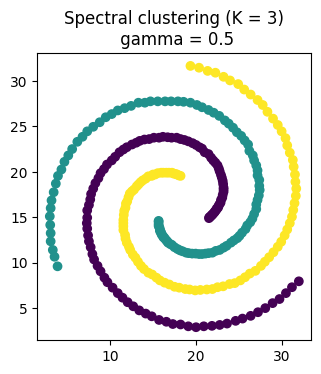

In [ ]:
k = 3

sigma = spirals.std()
spirals_affinity = rbf_kernel(spirals, gamma = 0.5)
result = SpectralClustering(n_clusters=k, affinity='precomputed').fit(spirals_affinity)
pred_labels = result.labels_

fig, ax = plt.subplots(1,1, figsize=(4,4))
fig.tight_layout(pad=3.0)
ax.scatter(spirals[:,0], spirals[:,1], c=pred_labels)
ax.set_title(f"Spectral clustering (K = {k})\n gamma = 0.5")
plt.show()

In [ ]:
spirals_affinity = rbf_kernel(spirals, gamma = 0.5)

# Degree matrix
D = np.diag(np.sum(spirals_affinity, axis=1))


# Normalized Laplacian
D_inv_sqrt = np.diag(1 / np.sqrt(np.diagonal(D)))
L_normalized = np.eye(D.shape[0]) - np.dot(D_inv_sqrt, np.dot(spirals_affinity, D_inv_sqrt))

We calculate the eigenvalues and eigenvectors of the normalized Laplacian. We remove the smallest eigenvalue and its corresponding eigenvector because they are approximately zero. We use the second and third smallest egienvectors to plot the spectral embedding

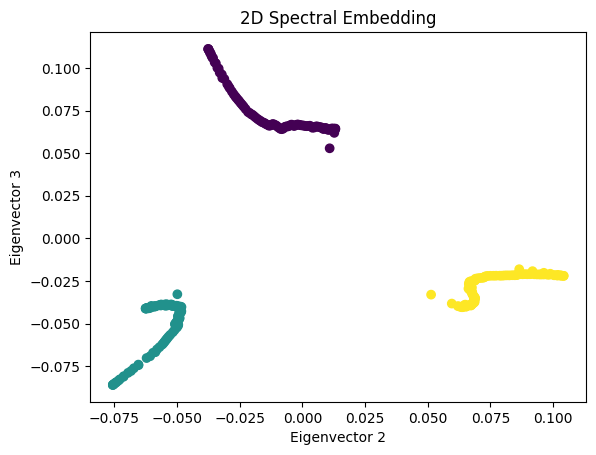

In [121]:
eigenvalues, eigenvectors = np.linalg.eigh(L_normalized)
sorted_indices = np.argsort(eigenvalues)

sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Skip the smallest eigenvalue (approximately zero)
eigenvalues = eigenvalues[1:]

#find the second and third smallest eigenvectors
x_spectral = eigenvectors[:,1:3]

plt.scatter(x_spectral[:, 0],x_spectral[:, 1], c=pred_labels)
plt.title('2D Spectral Embedding')
plt.xlabel('Eigenvector 2')
plt.ylabel('Eigenvector 3')
plt.show()


1. What is the SI value of the clustering in the embedded space? (This is very easy calculation, so if you have a need to evaluate pairwise distances etc, there is something wrong!).

In [125]:
print("The SI value of the clustering in the embedded space is")
SI_embedded = round(silhouette_index(x_spectral, pred_labels), 4)
print("SI embedded:", SI_embedded)


The SI value of the clustering in the embedded space is
SI embedded: 0.844


2. Why cannot you estimate the CH index of the clustering in the embedded space?



The embedding by the eigenvectors tries to preserve the relative distances between the datapoints based on the similarity graph. However, after transformation, the datapoints are reordered, albeit keeping their relative distance, so it is not necessarily true that the within cluster variance of the embedded space is the same as the one for the original space. Therefore, it is not meaningful to use the CH index in the embedded space since.

3. What is your opinion, could we evaluate the internal indices for spectral clustering in the new embedded space and compare with the K-means clustering?

The answer is relative to the formula of the internal indices.

For SI, we can use it for spectral clustering in the embedded space. This is because after transformation, the relative distance between each point is still preserved. This means that for the same datapoint, they are still near their own clusters and far away from other clusters, given the Euclidean distance. This can be seen from above, where SI embedded value is 0.84, while the SI value of K-means when K = 3 is 0.9, which are very close. FOr other number of clusters such as 2, 4 and 5, the values of SI are also close to each other in K-means and embedded spectral clustering.

For CH, we should not use it that since the within cluster variance is not preserved as argued from the previous answer.

Therefore, we should only use internal indices that only considers the relative distance between the datapoints for spectral clustering in the embedded space

## **Appendix**

All the code for this exercise has been added with respect to each part for closest referencing. Therefore, we do not attach any more code here in the Appendix section